In [3]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394484 sha256=ed4117b737710ca9602c8d4dff085c066eddc2cd8be5b41bb990904fdee236a3
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=180584 sha256=ac91acf4e96d34206d0d99b265e5e1bbc1f9ea4ca8ac380afc1806f1094c8e66
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting unin

In [4]:
from google.colab import output
from hazm import *
import json
import pickle
import string
import re

In [6]:
normalizer = Normalizer(remove_diacritics=True, token_based=False)
stemmer = Stemmer()
lemmatizer = Lemmatizer()
    

In [ ]:

#file=open("/content/drive/MyDrive/Colab Notebooks/IR_data_news_12k.json", encoding='utf-8')
file = open("/content/IR_data_news_12k.json", 'r') 

data=json.load(file)
titles = []
contents = []
urls = []
for i in range(len(data)):
  i = str(i)
  titles.append (data[i]['title'])
  contents.append(data[i]['content'])
  urls.append(data[i]['url'])

my_documents = contents[0:10]
print (len(contents))

In [ ]:
def preprocess(documents):
  documents_tokens_list = []
  i=0
  for document in documents:
    tokens_list = []
    normalized_document = normalizer.normalize(document)
    tokens = word_tokenize(normalized_document)
    punctuation = list (string.punctuation) + ['https://', 'http://', 'انتهای پیام/', '://', '\\','/','؟', '،', '؛', '«', '»']
    for token in tokens:
      if ((token not in stopwords_list()) and (token not in punctuation)):
        tokens_list.append(lemmatizer.lemmatize(token))
    documents_tokens_list.append(tokens_list)
    output.clear()
    print ("{0:.9f}".format(i/len(contents)))
    i+=1
  return documents_tokens_list

In [ ]:
preprocess(my_documents)
#preprocess(contents)

In [ ]:
strings = ['«عمری دگر بِباید، بعد از فِراق ما را... کاین عمر صرف کردیم اندر امیــدواری.»' ,'«ترسم نماز صوفی با صحبت خیالت / باطل بُود که صورت بر قبله می‌نگاری...»']
stings_tokens = preprocess (strings)
for x in stings_tokens:
  print (x)

0.000081954
['عمر', 'دگر', 'بباید', 'فراق', '…', 'کاین', 'عمر', 'کرد#کن', 'اندر', 'امیدوار']
['ترسید#ترس', 'نماز', 'صوف', 'صحبت', 'خیال', 'باطل', 'صورت', 'قبله', 'می\u200cنگاری', '…']


Objects of this class, save a token, its postings list, its positions in each posting, the term's frequency in each doc, and the term frequency in all documents.

In [7]:
class Token:
  def __init__(self, token):
    self.token = token
    self.postings_list = {}
    self.tf = {}
    self.df = 0
  
  def add_postings(self, docID, position):
    if docID not in self.postings_list:
      self.postings_list[docID] = [position]
      self.tf[docID] = 0
      self.df +=1
    else:
      self.postings_list[docID].append(position)
    self.tf[docID] += 1

  def get_postings(self):
    return self.postings_list

In [8]:
class Query:
  def __init__(self, string):
    self.main_query = string
    self.not_tokens = []
    self.phrases = []
    self.other_tokens = []
    self.process_query()

  def process_query (self):
    #look for phrases in query and add them to self.phrases array
    phrases = re.findall('"[^"]*"', self.main_query)
    for phrase in phrases:
      self.phrases.append(phrase.split('\"')[1])

    normalized_query = normalizer.normalize(self.main_query)
    initial_tokens = word_tokenize(normalized_query)
    punctuation = list (string.punctuation) + ['https://', 'http://', 'انتهای پیام/', '://', '\\','/','؟', '،', '؛', '«', '»']
    # print (initial_tokens)
    #look for not tokens in query and add them to self.not_tokens array
    for index, token in enumerate(initial_tokens):
      if (token not in stopwords_list()):
        if token == "!" and index != (len(initial_tokens)-1):
          self.not_tokens.append(lemmatizer.lemmatize(initial_tokens[index+1]))
        
    #look for other tokens that are not a phrase or not_token
    for token in initial_tokens:
      if token not in punctuation and token not in self.not_tokens:
        self.other_tokens.append(lemmatizer.lemmatize(token))

        #check if token is in any phrase
        for phrase in self.phrases:
          normalized_phrase = normalizer.normalize(phrase)
          phrase_tokens = word_tokenize(normalized_phrase)
          for phrase_token in phrase_tokens:
            if phrase_token in stopwords_list():
              phrase_tokens.remove(token)

          if token in phrase_tokens:
            self.other_tokens.remove(token)

  def get_not_tokens(self):
    return self.not_tokens

  def get_other_tokens(self):
    return self.other_tokens

  def get_phrases(self):
    return self.phrases


#test class
mystring = Query('آمریکا "تحریم هسته ای" ! ایران')
print (mystring.get_phrases())
print (mystring.get_not_tokens())
print (mystring.get_other_tokens())

['تحریم هسته ای']
['ایران']
['آمریکا']


In [22]:
class PositionalIndex:
  def __init__(self):
    self.index = {}

  def add_token(self, token, docID, position):
    if token not in self.index:
      new_token = Token(token)
      new_token.add_postings(docID, position)
      self.index[token] = new_token
    else:
      self.index[token].add_postings(docID, position)

  def retrieve(self, stringquery):
    query = Query(stringquery)
    not_tokens = query.get_not_tokens()
    phrases = query.get_phrases()
    other_tokens = query.get_other_tokens()
    print ('phrases:', phrases)
    print ('not_tokens: ', not_tokens)
    print ('other_tokens: ', other_tokens)
    result = {}
    len_phrases = len(phrases)
    if (len_phrases > 0):
      for i in range(len_phrases):
        phrase = Query(phrases[i])
        tokens = phrase.get_other_tokens()
        phrase_postings_list = phrase_positions(tokens)
        if len(result)==0:
          result = phrase_postings_list
        else:
          result = intersect(result, phrase_postings_list)
      # 'result' is now a list of postings with all phrase queries

    if (len(other_tokens) > 0):
      for token in other_tokens:
        # print (token)
        postings = self.index[token].get_postings()
        if len(result)==0:
          result = postings
        else:
          result = intersect(result, postings)
        # print ('success')
      # 'result' is now a list of postings with all phrase queries and all tokens in it.

    if (len(not_tokens) > 0):
      for token in not_tokens:
        not_postings = self.index[token].get_postings()
        if len(result)==0:
          continue
        else:
          result = intersect(result, not_postings, notp2=True)

    return result

**Do not run the following two blocks. it takes time. run the next block.**

In [ ]:
#building the Positional Index using our documents
main_index = PositionalIndex()
documents_tokens_list = preprocess(contents)
for docID in range(len(documents_tokens_list)):
  doc_tokens_list = documents_tokens_list[docID]
  positions = []
  for position, token in enumerate(doc_tokens_list):
    main_index.add_token(token, docID, position)

#test
print (main_index.index['گزارش'].get_postings())

0.999918046
{0: [0], 1: [0], 2: [0], 3: [0], 4: [0], 5: [0], 6: [0, 55], 7: [0], 8: [0], 9: [0], 10: [0], 11: [0], 12: [0], 13: [0], 14: [0], 15: [0], 16: [0], 17: [0, 58], 18: [0], 19: [0, 59, 79], 20: [0], 21: [0], 22: [0], 23: [0], 24: [0], 25: [0, 33, 43], 26: [0], 28: [0, 43, 126], 30: [0], 32: [0], 33: [0], 34: [0], 35: [0], 36: [0], 37: [0], 38: [0], 39: [0], 40: [0], 41: [0], 42: [0], 43: [0], 45: [0], 46: [0], 47: [0], 48: [0], 49: [0], 51: [0], 52: [0], 53: [0], 54: [0], 55: [0], 56: [0], 57: [0], 58: [0], 59: [0], 60: [0], 61: [0], 62: [0], 63: [0], 65: [0], 66: [0], 67: [0], 68: [0, 231], 69: [0], 70: [0], 72: [0], 73: [0], 74: [0], 75: [0], 76: [0, 104], 77: [0, 24], 78: [0], 79: [0], 80: [0], 81: [0], 82: [0], 83: [0], 84: [0], 85: [0], 86: [0], 87: [0], 88: [0], 89: [0], 90: [0], 92: [0], 93: [0], 94: [0], 95: [0], 96: [0], 97: [0], 98: [0], 99: [0], 100: [0], 101: [0], 102: [0], 103: [0], 105: [0], 106: [0], 107: [0], 108: [0], 109: [0, 28], 110: [0], 111: [0], 112: [0,

In [ ]:
with open('./dictionary.pkl', 'wb') as output_file:
  pickle.dump(main_index, output_file)

**Run from here.**

In [24]:
with open ('./dictionary.pkl', 'rb') as input:
  main_index = pickle.load(input)

                                              ب) پرسمان از کلمات ساده و متداول: تحریم ایران توسط آمریکا

In [25]:
print (list(main_index.retrieve ('تحریم ایران اسلامی').keys()))

phrases: []
not_tokens:  []
other_tokens:  ['تحریم', 'ایران', 'اسلام']
[1392, 2388, 2788, 3762, 5268, 6845, 6851, 6889, 6895, 6903, 6926, 6929, 6942, 6945, 6946, 6953, 6954, 6959, 6963, 7006, 7024, 7026, 7035, 7044, 7049, 7059, 7061, 7078, 7079, 7084, 7093, 7109, 7112, 7160, 7167, 7180, 7183, 7197, 7202, 7220, 7230, 7252, 7257, 7259, 7265, 7266, 7272, 7274, 7280, 7294, 7301, 7315, 7330, 7346, 7347, 7367, 7383, 7395, 7406, 7416, 7423, 7428, 7434, 7437, 7439, 7450, 7467, 7479, 7480, 7485, 7501, 7514, 7525, 7526, 7531, 7532, 7533, 7535, 7539, 7542, 7544, 7575, 7589, 7591, 7597, 7600, 7603, 7619, 7621, 7622, 7634, 7639, 7640, 7660, 7666, 7681, 7682, 7686, 7711, 7714, 7718, 7720, 7725, 7731, 7736, 7741, 7744, 7750, 7752, 7756, 7761, 7764, 7775, 7778, 7783, 7787, 7789, 7797, 7804, 7805, 7807, 7809, 7816, 7827, 7838, 7842, 7849, 7852, 7855, 7857, 7859, 7860, 7861, 7866, 7868, 7870, 7876, 7886, 7890, 7891, 7895, 7901, 7904, 7935, 7959, 7983, 7993, 8024, 8027, 8052, 8055, 8057, 8076, 8083, 8098

                                              ب) پرسمان با عملگر نات: گزارش ! فارس

In [27]:
print (list (main_index.retrieve('گزارش انقلاب ! فارس').keys()))

phrases: []
not_tokens:  ['فارس']
other_tokens:  ['گزارش', 'انقلاب']
[6968, 7112, 10103, 11254, 11689, 12091]


In [28]:
print (list(main_index.retrieve('"خبرگزاری فارس گفت"').keys()))

phrases: ['خبرگزاری فارس گفت']
not_tokens:  []
other_tokens:  ['خبرگزاری', 'فارس', 'گفت#گو']
[5600, 6433, 10120, 11882]


                                              ب) پرسمان پیچیده: "تحریم سخت" ایران ! آمریکا

In [29]:
print (list(main_index.retrieve('ایران "تحریم سخت" ! آمریکا').keys()))

phrases: ['تحریم سخت']
not_tokens:  ['آمریکا']
other_tokens:  ['ایران']
[10139]


In [19]:
print (main_index.index['خبرگزاری'].get_postings())

{0: [1], 1: [1], 2: [1], 3: [1], 4: [3], 5: [1], 6: [1, 56], 7: [3], 8: [3, 97, 243], 9: [3], 10: [1], 11: [3], 12: [1], 13: [3], 14: [1], 15: [3], 16: [1], 17: [1], 18: [1], 19: [1], 20: [1], 21: [1], 22: [1], 23: [1], 24: [1], 25: [1], 26: [1], 27: [5], 28: [1], 29: [5], 30: [1], 31: [5], 32: [1], 33: [1], 34: [1], 35: [1], 36: [3], 37: [1], 38: [1], 39: [1], 40: [1], 41: [1], 42: [1], 43: [1], 44: [5], 46: [1], 47: [1], 48: [3], 49: [1], 50: [5], 51: [3], 52: [1], 53: [1], 54: [3], 55: [3], 56: [3], 57: [3], 58: [3], 59: [3], 60: [1], 61: [1], 62: [1], 63: [1], 64: [5], 65: [3], 66: [3], 67: [3], 68: [3], 69: [3], 70: [3], 71: [5], 72: [3], 73: [3], 74: [1], 75: [1], 76: [1], 77: [3], 78: [1], 79: [3], 80: [3], 81: [1], 82: [3], 83: [3], 84: [1], 85: [1], 86: [3], 87: [1], 88: [1], 89: [3], 90: [1], 91: [5], 92: [1], 93: [1], 94: [1], 95: [1], 96: [3], 97: [1], 98: [1], 99: [1], 100: [1], 101: [1], 102: [1], 103: [1], 104: [6], 105: [1], 106: [3, 275], 107: [1], 108: [1], 109: [1], 

In [13]:
#finding related documents for a given postings lists

def intersect(p1, p2, notp2=False, k=0): #if notp2=True, we will intersect p1 with !p2 | k is distance we want between p1 and p2. default is 1
  result = []
  i=0
  j=0
  
  p1_keys = list(p1.keys())
  p2_keys = list(p2.keys())
  while (i<len(p1_keys) and j<len(p2_keys)):
    if notp2:
      if p1_keys[i] == p2_keys[j]:
        i += 1
        j += 1
      elif p1_keys[i] < p2_keys[j]:
        result.append(p1_keys[i])
        i += 1
      else:
        j += 1

    elif k != 0:
      if (p1_keys[i] == p2_keys[j]):
        for pos in p1[p1_keys[i]]:
          if pos+k in p2[p2_keys[j]]:
            result.append(p1_keys[i])
        i += 1
        j += 1
      elif (p1_keys[i] < p2_keys[j]):
        i += 1
      else:
        j += 1

    else:
      if p1_keys[i] == p2_keys[j]:
        result.append(p1_keys[i])
        i += 1
        j += 1
      elif p1_keys[i] < p2_keys[j]:
        i += 1
      else:
        j += 1
  return dict.fromkeys(result, [])

In [14]:
#this function gets two postings lists for two tokens in a row
#checks if the positions of two tokens in the same docs are in a row or not.
#returns a list of positions of the first token.
def phrase_positions(phrase_tokens):
  results = []
  phrase_len = len(phrase_tokens)
  for i in range(phrase_len-1):
    for j in range(i+1, phrase_len):
      distance = j - i
      p1 = main_index.index[phrase_tokens[i]].get_postings()
      p2 = main_index.index[phrase_tokens[j]].get_postings()
      results.append(intersect(p1, p2, k=distance))
  # print (len(results))
  # for r in results:
  #   print (r)
  try:
    return dict.fromkeys(list(set.intersection(*map(set, results))),[])
  except TypeError:
    return dict.fromkeys(result, [])
  return dict.fromkeys(result, [])

**Zipf's law**

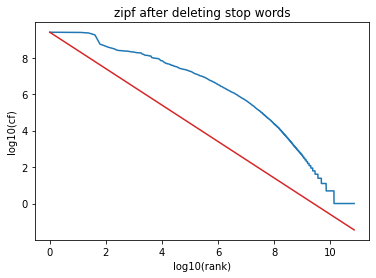

In [183]:
import matplotlib.pyplot as plt  
import numpy as np
#zipf : terms- df
def zipf(tokenList, name):
  zipf = {}
  def func(x):
    return zipf[x]
  for t in tokenList:
    zipf[t] =  tokenList[t].df
  zipf = sorted(zipf.items(), key=lambda x:x[1],reverse = True )
  x = []
  y = []
  tl = []
  z = []
  maxVal = zipf[0][1]
  for i in range(len(zipf)):
    tl.append(i + 1)
    x.append(np.log(i + 1))
    y.append(np.log(zipf[i][1])) 
    z.append(np.log(maxVal / (i + 1)))

  
  #zipf for our words
  plt.plot(x, y, color ='tab:blue')
  plt.plot(x,z, color ='tab:red')

  plt.xlabel('log10(rank)')
  # naming the y axis
  plt.ylabel('log10(cf)')
  plt.title(name) 
  plt.show()#print(zipf)  


# zipf(contents, 'zipf before removing stop words')
zipf(main_index.index ,'zipf after deleting stop words')  

In [ ]:
import numpy as np
tfIdf_list = {}
for t in main_index.index:
  tfIdf = {}
  for key  in main_index.index[t].tf:
    tfIdf[key] = (1 + np.log(main_index.index[t].tf[key])) *np.log(len(my_documents) /main_index.index[t].df)
  tfIdf_list[t] = tfIdf

#print(tfIdf_list)
print(tfIdf_list['فوتبال'])

{0: 0.8649029646371627, 1: 0.8649029646371627, 2: 0.5108256237659907, 3: 1.5048463894497432, 7: 0.5108256237659907, 9: 0.5108256237659907}


In [ ]:

#Document vectors

docVectors = []
vector = {}
 
for i in range(len(my_documents)):
  vector[i] = {}
  for t in main_index.index:
    if i in tfIdf_list[t]:
      (vector[i])[t] = (tfIdf_list[t])[i]
    else:
        (vector[i])[t] = 0
  docVectors.append(vector)

print(docVectors) 



[{0: {'گزارش': 0.0, 'خبرگزاری': 0.0, 'فارس': 0.0, 'کنفدراسیون': 1.6094379124341003, 'فوتبال': 0.8649029646371627, 'آسیا': 3.840592615014062, 'AFC': 2.302585092994046, 'نامه': 2.302585092994046, 'رسم': 2.302585092994046, 'فدراسیون': 0.6931471805599453, 'ایران': 1.1736001944781467, 'باشگاه': 1.808724531849926, 'گیتی': 4.8322333718613075, 'پسند': 4.8322333718613075, 'زمان': 1.6094379124341003, 'قرعه': 3.8986154582022285, 'کشید#کش': 3.8986154582022285, 'جام': 2.5266721223806154, 'فوتسال': 5.494645823410411, 'رسما': 2.302585092994046, 'اعلام': 1.2039728043259361, 'اساس': 2.302585092994046, '۲۵': 1.2039728043259361, 'فروردین': 2.302585092994046, 'ماه': 2.302585092994046, '۱۴۰۱': 2.302585092994046, 'مراسم': 1.6094379124341003, 'مالزی': 1.6094379124341003, 'برگزار': 0.3566749439387324, 'بعنوان': 2.302585092994046, 'قهرمان': 2.725015263724081, 'سال': 1.2039728043259361, '۱۴۰۰': 2.302585092994046, 'مسابقات': 2.0385031591153098, 'تجربه': 1.6094379124341003, '۳': 1.6094379124341003, 'دوره': 2.7250

In [ ]:
#Query 
query = 'فوتبال آسیا'
def queryTokeize(q):
  tokens_list = []
  normalized_document = normalizer.normalize(q)
  tokens = word_tokenize(normalized_document)
  punctuation = list (string.punctuation) + ['https://', 'http://', 'انتهای پیام/', '://', '\\','/','؟', '،', '؛', '«', '»']
  for token in tokens:
    if ((token not in stopwords_list()) and (token not in punctuation)):
      tokens_list.append(lemmatizer.lemmatize(token))
  return tokens_list

tokenizedQuery = queryTokeize(query)
#print(queryTokeize(query))
def QueryToken(q, dfs):

#calculate tf for each token
  tfIdfs = {}
  for t in q:
    tfIdfs[t] = 0
  
  #calculate tfs  
  for t in q:
    for i in range(len(q)):
      if q[i] == t:
          tfIdfs[t] = tfIdfs[t] + 1
  print(tfIdfs)       
  #calculate idfs
  for t in q:
    if t in dfs:
      tfIdfs[t] = (1 + np.log(tfIdfs[t])) * np.log(len(my_documents)/ dfs[t])
    else:
       tfIdfs[t] = 0  
  return tfIdfs  

#find dfs
dfs = {}
for t in main_index.index:
  dfs[t] = main_index.index[t].df
#print(dfs)

QtfIdfs = QueryToken(tokenizedQuery, dfs)
print(QtfIdfs)

{'فوتبال': 1, 'آسیا': 1}
{'فوتبال': 0.5108256237659907, 'آسیا': 1.6094379124341003}


In [ ]:
#calculate scores
scores = {}
def calScore(q,doc):
  score = 0
  dummy = 0
  a2 = 0
  b2 = 0
  for qt in q:
    if qt in doc and doc[qt] != 0:
      dummy += q[qt] * doc[qt]
      a2 += q[qt] ** 2
      b2 += doc[qt] ** 2
  if (a2 * b2 != 0):    
    score = dummy / a2^(0.5) * b2^(0.5)
  return score
print(docVectors[0])
for i in range(len(docVectors)):
  scores[i] = calScore(tokenizedQuery,docVectors[i]) 
#print(scores)
def valReturn(k):
  return scores[k]
dict(sorted(scores.items(), key=lambda item: item[1]))  
#print(scores)

{0: {'گزارش': 0.0, 'خبرگزاری': 0.0, 'فارس': 0.0, 'کنفدراسیون': 1.6094379124341003, 'فوتبال': 0.8649029646371627, 'آسیا': 3.840592615014062, 'AFC': 2.302585092994046, 'نامه': 2.302585092994046, 'رسم': 2.302585092994046, 'فدراسیون': 0.6931471805599453, 'ایران': 1.1736001944781467, 'باشگاه': 1.808724531849926, 'گیتی': 4.8322333718613075, 'پسند': 4.8322333718613075, 'زمان': 1.6094379124341003, 'قرعه': 3.8986154582022285, 'کشید#کش': 3.8986154582022285, 'جام': 2.5266721223806154, 'فوتسال': 5.494645823410411, 'رسما': 2.302585092994046, 'اعلام': 1.2039728043259361, 'اساس': 2.302585092994046, '۲۵': 1.2039728043259361, 'فروردین': 2.302585092994046, 'ماه': 2.302585092994046, '۱۴۰۱': 2.302585092994046, 'مراسم': 1.6094379124341003, 'مالزی': 1.6094379124341003, 'برگزار': 0.3566749439387324, 'بعنوان': 2.302585092994046, 'قهرمان': 2.725015263724081, 'سال': 1.2039728043259361, '۱۴۰۰': 2.302585092994046, 'مسابقات': 2.0385031591153098, 'تجربه': 1.6094379124341003, '۳': 1.6094379124341003, 'دوره': 2.72501

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [ ]:
#champion list
championList = {}
numSelect = 5
for t in tfIdf_list:
  #dict(sorted(tfIdf_list[t].items(), reverse= True))
  if(len(tfIdf_list[t].items()) > numSelect):
    championList[t] = sorted(tfIdf_list[t].items(), reverse= True)[:numSelect]
  else:
    championList[t] = sorted(tfIdf_list[t].items(), reverse= True)
  
  #print(championList.keys()) 

dict_keys(['گزارش'])
dict_keys(['گزارش', 'خبرگزاری'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه', 'رسم'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه', 'رسم', 'فدراسیون'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه', 'رسم', 'فدراسیون', 'ایران'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه', 'رسم', 'فدراسیون', 'ایران', 'باشگاه'])
dict_keys(['گزارش', 'خبرگزاری', 'فارس', 'کنفدراسیون', 'فوتبال', 'آسیا', 'AFC', 'نامه', 'رسم', 'فدراس

In [ ]:
#select from championList
